In [1]:
import os
import matplotlib.pyplot as pit
from nilearn.image import mean_img,load_img
from nilearn.plotting import plot_stat_map, plot_anat, plot_img,show, plot_glass_brain
from bids.layout import BIDSLayout
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import nibabel as nib
import numpy as np 
import networkx as nx

%matplotlib inline

In [3]:
fmriprep_dir='../../Full-Dataset'
layout=BIDSLayout(fmriprep_dir)

In [5]:
events=pd.read_table('../../Full-Dataset/task-speech_events.tsv')
print(events)

    onset  duration   trial_type
0       0        26  white-noise
1      28        26    sentences
2      56        26        words
3      84        26     reversed
4     112        26  white-noise
5     140        26        words
6     168        26     reversed
7     196        26    sentences
8     224        26  white-noise
9     252        26     reversed
10    280        26    sentences
11    308        26        words
12    336        26  white-noise
13    364        26    sentences
14    392        26     reversed
15    420        26        words
16    448        26  white-noise
17    476        26     reversed
18    504        26        words
19    532        26    sentences
20    560        26  white-noise
21    588        26        words
22    616        26    sentences
23    644        26     reversed


In [8]:
nifti_file_path=layout.get(subject='32',datatype='func',extension='.nii.gz',return_type="file")
img = nib.load(nifti_file_path[0])

In [11]:
import pandas as pd
import nibabel as nib

def extract_fmri_data(tsv_path, img, condition='sentences', duration=13):
    # Load TSV data into a DataFrame
    df = pd.read_csv(tsv_path, delimiter='\t')

    # Extract time points for the specified condition
    condition_time_points = df.loc[df['trial_type'] == condition, 'onset']

    # Create a list of time points for each occurrence of the specified condition
    condition_occurrences = []
    for onset in condition_time_points:
        condition_occurrences.extend(range(int(onset), int(onset) + duration))

    # Extract corresponding time points from fMRI data
    condition_fmri_data = img.get_fdata()[:, :, :, condition_occurrences]

    return condition_occurrences, condition_fmri_data

# Example usage
tsv_path = 'my.tsv'
nifti_img = nib.load(nifti_file_path[0])  # Replace with the actual path
condition_occurrences, condition_fmri_data = extract_fmri_data(tsv_path, nifti_img)

# Print or use the extracted fMRI data for the specified condition
print(condition_occurrences)
print(condition_fmri_data.shape)


[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320]
(96, 96, 32, 78)


In [16]:
from nilearn import datasets, maskers, image, connectome
from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
from bids.layout import BIDSLayout
import numpy as np

def create_fc_matrices(sentences_type):
    fmriprep_dir = '../../Full-Dataset'
    tsv_path = 'my.tsv'
    layout = BIDSLayout(fmriprep_dir)
    msdl_atlas = datasets.fetch_atlas_msdl()

    print(f'Number of labels in the atlas: {len(msdl_atlas.labels)}\n')

    fmri_files = layout.get(subject='01',datatype='func', extension='.nii.gz', return_type="file")

    print(f'Number of Subjects in the Dataset: {len(fmri_files)}\n')

    masker = maskers.NiftiMapsMasker(maps_img=msdl_atlas.maps, standardize='zscore_sample', verbose=0)
    correlation_measure = connectome.ConnectivityMeasure(kind='correlation', standardize='zscore_sample')

    subject_corr_data = []
    time_series_data = []

    for file in fmri_files:
        fmri_data = image.load_img(file)
        condition_occurrences, condition_fmri_data = extract_fmri_data(tsv_path, fmri_data)
        # Extract time series for the entire run
        time_series = masker.fit_transform(fmri_data) 

        # print("Shape of time_series:", selected_time_series.shape)
        # print("Maximum index in sentences_occurrences:", max(sentences_occurrences))
        
        # Select only the time points corresponding to "sentences_occurrences"
        # valid_indices = [idx for idx in sentences_occurrences if idx < time_series.shape[1]] 
        selected_time_series = time_series[condition_occurrences,:] 
        corr_matrix = correlation_measure.fit_transform([selected_time_series])[0]
        time_series_data.append(selected_time_series)
        subject_corr_data.append(corr_matrix)
        print(f'Subjects left to Compute {len(fmri_files) - len(subject_corr_data)}')

    return subject_corr_data, time_series_data

# Assuming you already have sentences_occurrences from your previous step
# Call the function with the specified time points
subject_corr_data, time_series_data = create_fc_matrices('sentences')


Number of labels in the atlas: 39

Number of Subjects in the Dataset: 1

Subjects left to Compute 0


In [153]:
np.save('C:\\Users\\kuttysidtej\\Desktop\\mri-research\\source_data\\fc\\fc_matrices1',subject_corr_data)
np.save("C:\\Users\\kuttysidtej\\Desktop\\mri-research\\source_data\\time_series1",time_series_data)

In [154]:
fc_matrices=np.load("C:\\Users\\kuttysidtej\\Desktop\\mri-research\\source_data\\fc\\fc_matrices1.npy")

In [19]:
fc_matrices=subject_corr_data

In [20]:
msdl_atlas = datasets.fetch_atlas_msdl()
msdl_labels = msdl_atlas.labels
msdl_coords = msdl_atlas.region_coords

In [21]:
len(fc_matrices)

1

In [32]:
def create_knn_graph(fc_matrices, k):
    # Calculate group FC matrix by averaging individual FC matrices
    group_fc_matrix_strength = np.mean(fc_matrices, axis=0)
    print(f'Shape of mean fc corr (strength) {group_fc_matrix_strength.shape}')
    print(group_fc_matrix_strength)

    # Create k-NN graph
    G = nx.Graph()
    num_nodes = group_fc_matrix_strength.shape[0]

    for i in range(num_nodes):
        # Find the indices of the top k edges in terms of connectivity strength
        top_k_indices = np.argsort(group_fc_matrix_strength[i, :])[-k:]

        # Add edges to the graph
        for j in top_k_indices:
            if i != j:  # Avoid self-loops
                G.add_edge(i, j, weight=500000000*group_fc_matrix_strength[i, j])
    return G, group_fc_matrix_strength

Shape of mean fc corr (strength) (39, 39)
[[ 1.          0.57717419  0.17748709 ...  0.00790014  0.50094252
   0.36083764]
 [ 0.57717419  1.          0.28652722 ...  0.08415937  0.37792654
   0.52490644]
 [ 0.17748709  0.28652722  1.         ...  0.56901415  0.03562165
   0.16212403]
 ...
 [ 0.00790014  0.08415937  0.56901415 ...  1.         -0.2486613
  -0.14567174]
 [ 0.50094252  0.37792654  0.03562165 ... -0.2486613   1.
   0.40531234]
 [ 0.36083764  0.52490644  0.16212403 ... -0.14567174  0.40531234
   1.        ]]


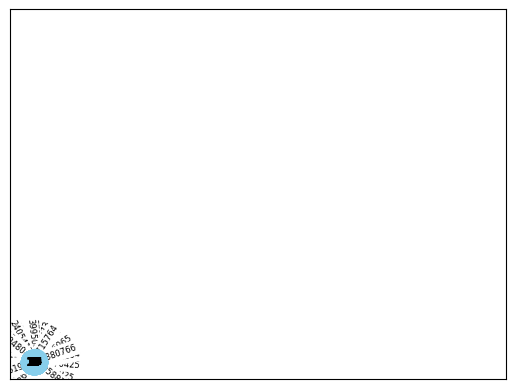

In [33]:
# Create the graph
k=5
G, group_fc_matrix_strength = create_knn_graph(fc_matrices, k)
# Visualize the graph
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, font_size=8)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.show()

In [159]:
print(len(pos))

13


In [165]:
adjacency_matrix = nx.adjacency_matrix(G).todense()
labels = list(G.nodes)

NameError: name 'labels' is not defined

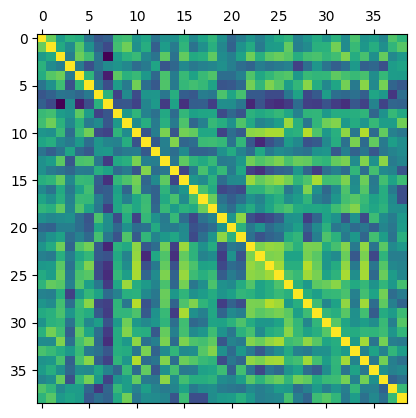

In [35]:
# Visualize the adjacency matrix
fig, ax = plt.subplots()
cax = ax.matshow(fc_matrices[0], cmap='viridis')

# Add labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Display the colorbar
fig.colorbar(cax)

plt.show()

In [36]:
print(fc_matrices[0].shape)

(39, 39)


In [37]:
print(len(msdl_labels))

39
